In this notebook we will run a first mechanistic interpetability experiment on vision-action model.
The model is an ACT model trained on pick-and-place task via teleoperation.
The current checkpoint succeed to overfit to the 5 initial position dataset while faile in every other inital location. We will investigate the internals of the network to try gain some insights on the internal representation of the world for understading the failure cases.

In [1]:
import os
from huggingface_hub import snapshot_download
from ACT_model_from_hf import ACTPolicy
import cv2
from PIL import Image
import torch
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import einops

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_pretrained_model_from_hf(repo_id):
    current_dir = os.getcwd()
    parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
    model_name = repo_id.split('/')[-1]
    local_dir = os.path.join(parent_dir, "models", model_name)
    # snapshot_download(repo_id=repo_id, local_dir=local_dir)
    return local_dir

repo_id = "yanivmel1/new_dataset_cube_080000"
model_dir = load_pretrained_model_from_hf(repo_id)
policy = ACTPolicy.from_pretrained(model_dir)
policy.to(device)
# policy.eval()  

Loading weights from local directory


ACTPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_images_laptop): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 3x1x1]
        (std): Parameter containing: [torch.FloatTensor of size 3x1x1]
    )
    (buffer_observation_images_phone): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 3x1x1]
        (std): Parameter containing: [torch.FloatTensor of size 3x1x1]
    )
    (buffer_observation_state): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 6]
        (std): Parameter containing: [torch.FloatTensor of size 6]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 6]
        (std): Parameter containing: [torch.FloatTensor of size 6]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 6]


In [4]:
dataset_path = r'C:\Users\t-ymelamed\OneDrive - Microsoft\Desktop\personal\Robot\mechinterp\data\new_dataset_cube'

# 0.1 find cube location feature in resnet backbone

In [148]:
def load_image(image_path):
    image = Image.open(image_path)
    image = ToTensor()(image)
    image = image.unsqueeze(0)
    return image

def save_n_first_frames(video_path, output_dir, n):
    # get file name without extension
    fname = os.path.splitext(os.path.basename(video_path))[0]
    video_capture = cv2.VideoCapture(video_path)
    for i in range(n):
        ret, frame = video_capture.read()
        output_path = os.path.join(output_dir, f"{fname}_frame_{i}.png")
        cv2.imwrite(output_path, frame)
    video_capture.release()

def save_all_frames(video_path, output_dir):
    video_capture = cv2.VideoCapture(video_path)
    i = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        output_path = os.path.join(output_dir, f"frame_{i}.png")
        cv2.imwrite(output_path, frame)
        i += 1
    video_capture.release()

In [7]:
right_corner_video_indices = ['000000', '000005', '000010', '000015', '000020', '000025', '000030', '000035', '000040', '000045']  
left_corner_video_indices = ['000004', '000009', '000014', '000019', '000024', '000029', '000034', '000039', '000044', '000049']
label_names = ['right_corner', 'left_corner']
num_of_frames = 30

In [ ]:
for vid_indecis_lst, label_name in zip([right_corner_video_indices, left_corner_video_indices], label_names):
    for vid_index in vid_indecis_lst:
        file_path = rf'\videos\observation.images.laptop_episode_{vid_index}.mp4'
        video_path = dataset_path + file_path
        output_dir = os.path.join(dataset_path, "frames", label_name)
        os.makedirs(output_dir, exist_ok=True)
        save_n_first_frames(video_path, output_dir, num_of_frames) 

In [96]:
cam_all_features_dataset = [] 
for vid_indecis_lst, label_name in zip([right_corner_video_indices, left_corner_video_indices], label_names):
    for vid_index in vid_indecis_lst:
        for i in range(num_of_frames):
            image_path = os.path.join(dataset_path, "frames", label_name, f"observation.images.laptop_episode_{vid_index}_frame_{i}.png")
            img = load_image(image_path)
            mean_img = policy.normalize_inputs.buffer_observation_images_laptop["mean"]
            std_img = policy.normalize_inputs.buffer_observation_images_laptop["std"]
            img = (img - mean_img) / (std_img + 1e-8)
            cam_features = policy.model.backbone(img)["feature_map"]
            cam_all_features_dataset.append((cam_features.squeeze(0), label_name)) # to get torch.Size([512, 15, 20])

In [97]:
# dataset per feature
single_feature_dataset = {} # keys will be 0 to num_of_features (511)
for feature_map, label in cam_all_features_dataset:
    for i in range(feature_map.shape[0]):
        if i not in single_feature_dataset:
            single_feature_dataset[i] = [] # list of N tupels, #0 tensor of shape (15, 20), #1 label as a string. N = num_of_videos # num of frames 
        single_feature_dataset[i].append((feature_map[i], label))

In [101]:
def linear_probe_accuarcy(data, batch_size=4, epochs=1, label="right_corner"):
    # Prepare data and labels
    X = torch.stack([item[0].flatten() for item in data])  # Flatten each tensor to a 1D vector
    y = torch.tensor([0 if item[1] == label else 1 for item in data])  # Convert labels to 0 or 1

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.clone().detach().float()
    X_test = X_test.clone().detach().float()
    y_train = y_train.clone().detach().float().unsqueeze(1)
    y_test = y_test.clone().detach().float().unsqueeze(1)

    # Define the model
    class LinearClassifier(nn.Module):
        def __init__(self, input_dim):
            super(LinearClassifier, self).__init__()
            self.linear = nn.Linear(input_dim, 1)

        def forward(self, x):
            return torch.sigmoid(self.linear(x))

    input_dim = X_train.shape[1]
    model = LinearClassifier(input_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Prepare data loader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        predictions = (test_outputs >= 0.9).float()  # Convert to binary predictions
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())

    return accuracy

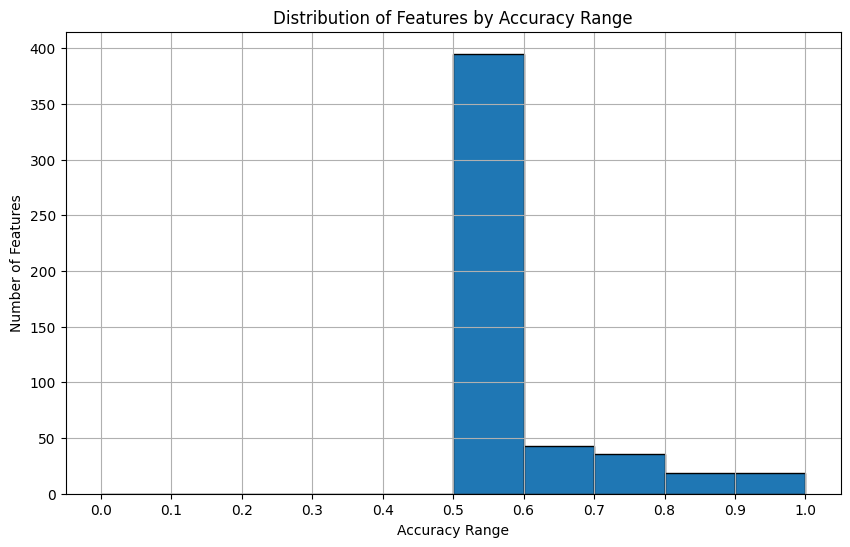

In [102]:
# Create lists to store feature indices and their corresponding accuracies
feature_indices = []
accuracies = []

# Loop through each feature and calculate accuracy
for i in range(feature_map.shape[0]):
    data = single_feature_dataset[i]
    acc = linear_probe_accuarcy(data, batch_size=8)  # Assumes this function returns accuracy for the feature
    feature_indices.append(i)
    accuracies.append(acc)

bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=bins, edgecolor='black')
plt.xlabel('Accuracy Range')
plt.ylabel('Number of Features')
plt.title('Distribution of Features by Accuracy Range')
plt.xticks(bins)  # Ensure x-axis labels match bin edges
plt.grid(True)
plt.show()



In [117]:
# get indecis of accuracies list with acc == 1
best_features = [i for i, acc in enumerate(accuracies) if acc == 1]
best_features

[134, 235, 340, 387]

In [127]:
features_map_of_5_initial_pos = []
first_frames_from_5_inital_pos_dir = os.path.join(dataset_path, "first_frame")
for file in os.listdir(first_frames_from_5_inital_pos_dir):
    img_path = os.path.join(first_frames_from_5_inital_pos_dir, file)
    img = load_image(img_path)
    mean_img = policy.normalize_inputs.buffer_observation_images_laptop["mean"]
    std_img = policy.normalize_inputs.buffer_observation_images_laptop["std"]
    norm_img = (img - mean_img) / (std_img + 1e-8)
    cam_features = policy.model.backbone(norm_img)["feature_map"]
    features_map_of_5_initial_pos.append((cam_features.squeeze(0), img)) #  torch.Size([512, 15, 20])
    

Text(0.5, 0.5, 'ResNet backbone output [15 X 20 X 512] Tensor. here we take [:,:,340]')

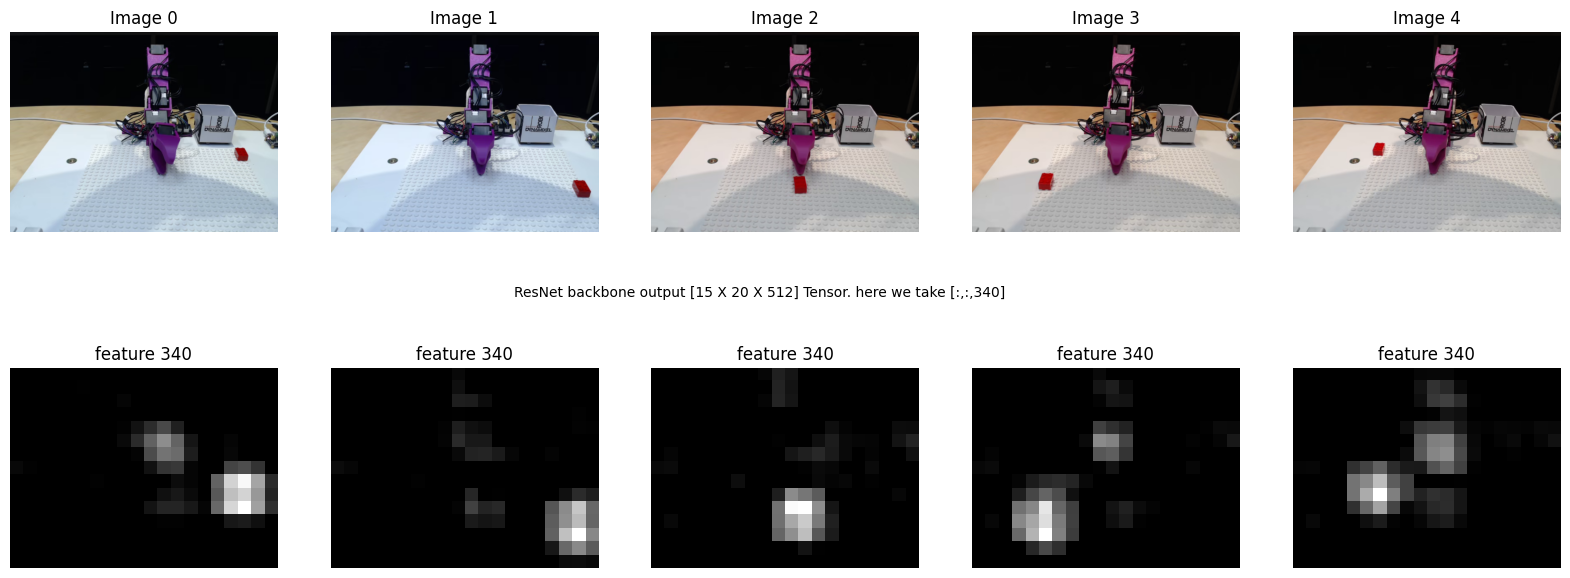

In [146]:
feature_idx = best_features[2]
single_faeture_5_initial_pos = []
for feature_map, img in features_map_of_5_initial_pos:
    single_faeture_5_initial_pos.append((feature_map[feature_idx], img))

# plot in grid of 2 rows first row is the image and the second row is the feature map
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, (feature_map, img) in enumerate(single_faeture_5_initial_pos):
    axs[0, i].imshow(img.squeeze(0).permute(1, 2, 0).numpy())
    axs[0, i].set_title(f'Image {i}')
    axs[0, i].axis('off')
    axs[1, i].imshow(feature_map.detach().numpy(), cmap='gray')
    axs[1, i].set_title(f'feature {feature_idx}')
    axs[1, i].axis('off')
# add text between the rows
fig.text(0.5, 0.5, f'ResNet backbone output [15 X 20 X 512] Tensor. here we take [:,:,{feature_idx}]', ha='center')

In [186]:
# save all frames of a video
vid_index = '000014'
file_path = rf'\videos\observation.images.laptop_episode_{vid_index}.mp4'
video_path = dataset_path + file_path
output_dir = os.path.join(dataset_path, "frames", f"video_{vid_index}")
os.makedirs(output_dir, exist_ok=True)
save_all_frames(video_path, output_dir) 

In [187]:
# get features of all frames of a video, evert 10 frames
all_frames_path = os.path.join(dataset_path, "frames", f"video_{vid_index}")
num_of_frames = len(os.listdir(all_frames_path))
video_features = []
video_frames = []
for i in range(0, num_of_frames, 10):
    image_path = os.path.join(all_frames_path, f"frame_{i}.png")
    img = load_image(image_path)
    mean_img = policy.normalize_inputs.buffer_observation_images_laptop["mean"]
    std_img = policy.normalize_inputs.buffer_observation_images_laptop["std"]
    norm_img = (img - mean_img) / (std_img + 1e-8)
    cam_features = policy.model.backbone(norm_img)["feature_map"]
    feature_of_interest = cam_features.squeeze(0)[best_features[2]]
    video_features.append(feature_of_interest)
    video_frames.append(img)

In [188]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_width = 320 + 320  # Combined width of resized color frame and feature (both 320)
output_height = 480  # Height of the frame (same as video_frames)
video_out = cv2.VideoWriter(f'combined_video_{vid_index}.mp4', fourcc, 10, (output_width, output_height))

for img_frame, feature in zip(video_frames, video_features):
    # Process the color image frame
    img_frame = img_frame.squeeze(0).permute(1, 2, 0).numpy()  # Convert to HWC format
    img_frame = (img_frame * 255).astype(np.uint8)  # Convert to 8-bit
    img_frame = cv2.resize(img_frame, (320, 480))  # Resize color frame to (320, 480)

    # Process the grayscale feature
    feature = feature.detach().numpy()  # Convert to numpy
    feature = cv2.resize(feature, (320, 480))  # Resize to (320, 480) to match image
    feature = cv2.normalize(feature, None, 0, 255, cv2.NORM_MINMAX)  # Normalize to 0-255
    feature = feature.astype(np.uint8)  # Convert to 8-bit grayscale

    # Convert grayscale feature to 3 channels
    feature = cv2.cvtColor(feature, cv2.COLOR_GRAY2BGR)

    # Concatenate the resized color image and the grayscale feature side-by-side
    combined_frame = cv2.hconcat([img_frame, feature])

    # Write the combined frame to the output video
    video_out.write(combined_frame)

video_out.release()


# 0.2 early stopping to locate layers contribution to output

In [ ]:
# what I wanted to do is:
# run a forward pass over the one rollout (from onset up to cube grasping) and save the policy output for every step to get the trajectory
# then N more rolouts on the same initail conditions, just each time removing one more layer
# then i will calculte trajectories distance to fing layer contribution to output.
# but since i need the robot for this let's do the following:
#  We will take onlt the first frame input image and get 100 steps predication from the policy
# we will compare this trajectories to cases were we eliminate layers. this will be a proxy to the full trajectory.          
# then we will calculate the distance between the trajectories to get the contribution of each layer to the output.


In [4]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

In [5]:
def create_delta_timestamps(fps, chunk_size):
    fps_value = fps
    delta_timestamps = {
        "action": [i / fps_value for i in range(chunk_size)]
    }
    return delta_timestamps

def modify_to_resnet_stats(dataset):
    # Define common statistics for both image sources
    common_stats = {
        "mean": [[[0.485]], [[0.456]], [[0.406]]],
        "std": [[[0.229]], [[0.224]], [[0.225]]]
    }
    keys = ["observation.images.laptop", "observation.images.phone"]
    for key in keys:
        for stats_type, value in common_stats.items():
            dataset.stats[key][stats_type] = torch.tensor(value, dtype=torch.float32)

In [7]:
repo_id = "yanivmel1/new_dataset_cube"
fps = 30
chunk_size = 100
image_transforms = None 
video_backend = 'pyav'
split='train'
delta_timestamps = create_delta_timestamps(fps, chunk_size)
dataset = LeRobotDataset(repo_id, split=split, delta_timestamps=delta_timestamps, image_transforms=image_transforms, video_backend=video_backend)
modify_to_resnet_stats(dataset)

Fetching 106 files:   0%|          | 0/106 [00:00<?, ?it/s]

In [8]:
def get_first_data_point_of_episode(dataset, target_episode_index):
    left, right = 0, dataset.num_samples - 1
    result = None
    while left <= right:
        mid = (left + right) // 2
        if dataset[mid]["episode_index"] == target_episode_index:
            if dataset[mid]["frame_index"] == 0:
                result = dataset[mid]
                break
            else:
                right = mid - 1
        elif dataset[mid]["episode_index"] < target_episode_index:
            left = mid + 1
        else:
            right = mid - 1
    return result

def prepare_input_to_model(data_point):
    data_point.pop('action')
    data_point.pop('action_is_pad')
    for key, value in data_point.items():
        data_point[key] = value.unsqueeze(0)
    batch = data_point
    with torch.no_grad():
        batch = policy.normalize_inputs(batch)
        if len(policy.expected_image_keys) > 0:
            batch = dict(batch)  # shallow copy so that adding a key doesn't modify the original
            batch["observation.images"] = torch.stack([batch[k] for k in policy.expected_image_keys], dim=-4)
    return batch

In [9]:
def get_policy_output(policy, batch):
    actions = policy.model(batch)[0][:, : policy.config.n_action_steps]
    actions = policy.unnormalize_outputs({"action": actions})["action"]
    return actions

In [170]:
def forward_pass(batch, policy):
    # encoder_in_tokens.shape # 602 tokens each in dim=512. 600 from 2 camers, 1 from robot state, 1 from latent sample (mu-sigma)
    # encoder_out.shape torch.Size([602, 1, 512]) - 602 tokens, 1 batch, 512 dim
    # decoder_in.shape - torch.Size([100, 1, 512]) - 100 "empty" tokens, 1 batch, 512 dim, each token is quering the decoder_out, which action it will be resulted
    # decoder_out.shape # torch.Size([1, 100, 512]) - 1 batch, 100 tokens, 512 dim the resulted action, before transforming to the action space

    batch_size = batch["observation.images"].shape[0]
    latent_sample = torch.zeros([batch_size, policy.model.config.latent_dim], dtype=torch.float32).to(batch["observation.state"].device)
    # Prepare transformer encoder inputs.
    encoder_in_tokens = [policy.model.encoder_latent_input_proj(latent_sample)]
    encoder_in_pos_embed = list(policy.model.encoder_1d_feature_pos_embed.weight.unsqueeze(1))
    # Robot state token.
    encoder_in_tokens.append(policy.model.encoder_robot_state_input_proj(batch["observation.state"]))
    # Camera observation features and positional embeddings.
    all_cam_features = []
    all_cam_pos_embeds = []
    for cam_index in range(batch["observation.images"].shape[-4]):
        cam_features = policy.model.backbone(batch["observation.images"][:, cam_index])["feature_map"]
        cam_pos_embed = policy.model.encoder_cam_feat_pos_embed(cam_features).to(dtype=cam_features.dtype)
        cam_features = policy.model.encoder_img_feat_input_proj(cam_features)  # (B, C, h, w)
        all_cam_features.append(cam_features)
        all_cam_pos_embeds.append(cam_pos_embed)
    # Concatenate camera observation feature maps and positional embeddings along the width dimension, and move to (sequence, batch, dim).
    all_cam_features = torch.cat(all_cam_features, axis=-1)
    encoder_in_tokens.extend(einops.rearrange(all_cam_features, "b c h w -> (h w) b c"))
    all_cam_pos_embeds = torch.cat(all_cam_pos_embeds, axis=-1)
    encoder_in_pos_embed.extend(einops.rearrange(all_cam_pos_embeds, "b c h w -> (h w) b c"))
    # Stack all tokens along the sequence dimension.
    encoder_in_tokens = torch.stack(encoder_in_tokens, axis=0)
    encoder_in_pos_embed = torch.stack(encoder_in_pos_embed, axis=0)
    
    # Forward pass through the transformer modules.
    encoder_out = policy.model.encoder(encoder_in_tokens, pos_embed=encoder_in_pos_embed)
    decoder_in = torch.zeros(
        (policy.model.config.chunk_size, batch_size, policy.model.config.dim_model),
        dtype=encoder_in_pos_embed.dtype,
        device=encoder_in_pos_embed.device,
    )
    
    # Forward pass through the decoder.
    decoder_out = policy.model.decoder(
        decoder_in,
        encoder_out,
        encoder_pos_embed=encoder_in_pos_embed,
        decoder_pos_embed=policy.model.decoder_pos_embed.weight.unsqueeze(1),
    )
    # Move back to (B, S, C).
    decoder_out = decoder_out.transpose(0, 1)
    actions = policy.model.action_head(decoder_out)
    actions = policy.unnormalize_outputs({"action": actions})["action"]
    return actions, encoder_in_tokens, encoder_in_pos_embed, decoder_in, encoder_out, encoder_in_pos_embed

def decoder_partial_forward_pass(decoder_in, encoder_out, encoder_pos_embed, decoder_pos_embed, policy):
    decoder_layer = policy.model.decoder.layers[0]
    x = decoder_in # torch.Size([100, 1, 512])
    skip = x
    if decoder_layer.pre_norm:
        x = decoder_layer.norm1(x)
    q = k = decoder_layer.maybe_add_pos_embed(x, decoder_pos_embed)
    x = decoder_layer.self_attn(q, k, value=x)[0]  # select just the output, not the attention weights
    x = skip + decoder_layer.dropout1(x)
    if decoder_layer.pre_norm:
        skip = x
        x = decoder_layer.norm2(x)
    else:
        x = decoder_layer.norm1(x)
        skip = x
    atten_out = decoder_layer.multihead_attn(
        query=decoder_layer.maybe_add_pos_embed(x, decoder_pos_embed),
        key=decoder_layer.maybe_add_pos_embed(encoder_out, encoder_pos_embed),
        value=encoder_out,
    )
    return atten_out

def plot_first_action_toke_atten_weight(atten_out):
    # len(atten_out) ==2
    # atten_out[0].shape # torch.Size([100, 1, 512]) - the output of the multihead attention which will be update the strem: skip + atten_out[0]
    atten_map = atten_out[1].squeeze(0).detach().numpy() # (100, 602) 
    token_weight_for_first_action = atten_map[0]
    plt.plot(token_weight_for_first_action)
    plt.xlabel('Token Index')
    plt.ylabel('Attention Weight')
    plt.title('Attention Weights for the First Action')
    plt.grid(True)
    plt.show()

def plot_full_atten_map(atten_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(atten_map, cmap='viridis', aspect='auto')
    plt.xlabel('Token Index')
    plt.ylabel('Action Index')
    plt.title('Attention Map for the First Action')
    plt.colorbar()
    plt.show()


In [156]:
initial_observation = dataset[250]
batch = prepare_input_to_model(initial_observation)
actions, encoder_in_tokens, encoder_in_pos_embed, decoder_in, encoder_out, encoder_in_pos_embed = forward_pass(batch, policy)
atten_out = decoder_partial_forward_pass(decoder_in, encoder_out, encoder_in_pos_embed, policy.model.decoder_pos_embed.weight.unsqueeze(1), policy)
atten_map = atten_out[1].squeeze(0).detach().numpy() # (100, 602) 
np.argmax(atten_map[0])

157

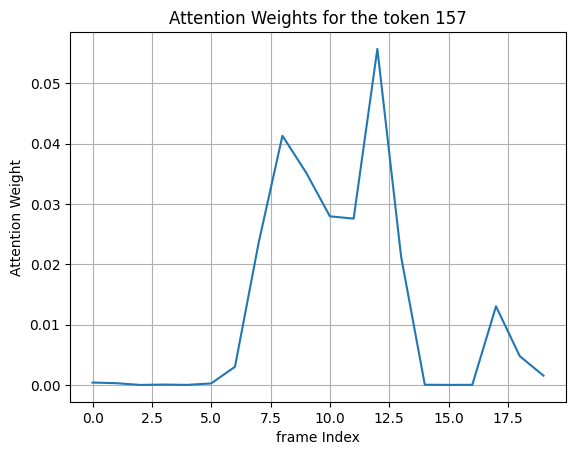

In [ ]:
token_weights = []
token_idx = 157
for i in range(0,600,30):
    initial_observation = dataset[i]
    batch = prepare_input_to_model(initial_observation)
    actions, encoder_in_tokens, encoder_in_pos_embed, decoder_in, encoder_out, encoder_in_pos_embed = forward_pass(batch, policy)
    atten_out = decoder_partial_forward_pass(decoder_in, encoder_out, encoder_in_pos_embed, policy.model.decoder_pos_embed.weight.unsqueeze(1), policy)
    atten_map = atten_out[1].squeeze(0).detach().numpy() # (100, 602) 
    token_weight = atten_map[0, token_idx]
    token_weights.append(token_weight)
plt.plot(token_weights)
plt.xlabel('frame Index')
plt.ylabel('Attention Weight')
plt.title(f'Attention Weights for the token {token_idx}')
plt.grid(True)
plt.show()



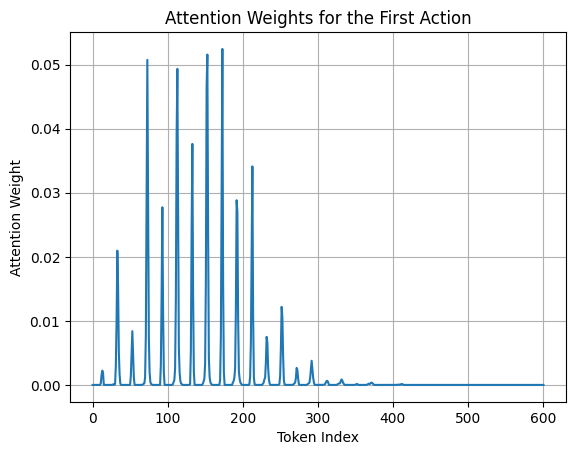

In [183]:
target_episode_index = 4
initial_observation = get_first_data_point_of_episode(dataset, target_episode_index)
batch = prepare_input_to_model(initial_observation)
actions, encoder_in_tokens, encoder_in_pos_embed, decoder_in, encoder_out, encoder_in_pos_embed = forward_pass(batch, policy)
atten_out = decoder_partial_forward_pass(decoder_in, encoder_out, encoder_in_pos_embed, policy.model.decoder_pos_embed.weight.unsqueeze(1), policy)
plot_first_action_toke_atten_weight(atten_out)
# action_chunk = get_policy_output(policy, batch)


In [184]:
# study the encoder

# policy.model.encoder(encoder_in_tokens, pos_embed=encoder_in_pos_embed).shape
def encoder_layer_forward_pass(layer, x, pos_embed):
    skip = x
    if layer.pre_norm:
        x = layer.norm1(x)
    q = k = x + pos_embed
    x = layer.self_attn(q, k, value=x, key_padding_mask=None)
    x, encoder_atten_map = x  # note: [0] to select just the output, not the attention weights
    x = skip + layer.dropout1(x)
    if layer.pre_norm:
        skip = x
        x = layer.norm2(x)
    else:
        x = layer.norm1(x)
        skip = x
    x = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
    x = skip + layer.dropout2(x)
    if not layer.pre_norm:
        x = layer.norm2(x)
    return x, encoder_atten_map

def encoder_forward_pass(policy, encoder_in_tokens, encoder_in_pos_embed):
    encoder_atten_map_lst = []
    x = encoder_in_tokens
    for layer in policy.model.encoder.layers:
        x, encoder_atten_map = encoder_layer_forward_pass(layer, x, encoder_in_pos_embed)
        encoder_atten_map_lst.append(encoder_atten_map)
    return x, encoder_atten_map_lst

x, encoder_atten_map_lst = encoder_forward_pass(policy, encoder_in_tokens, encoder_in_pos_embed)   

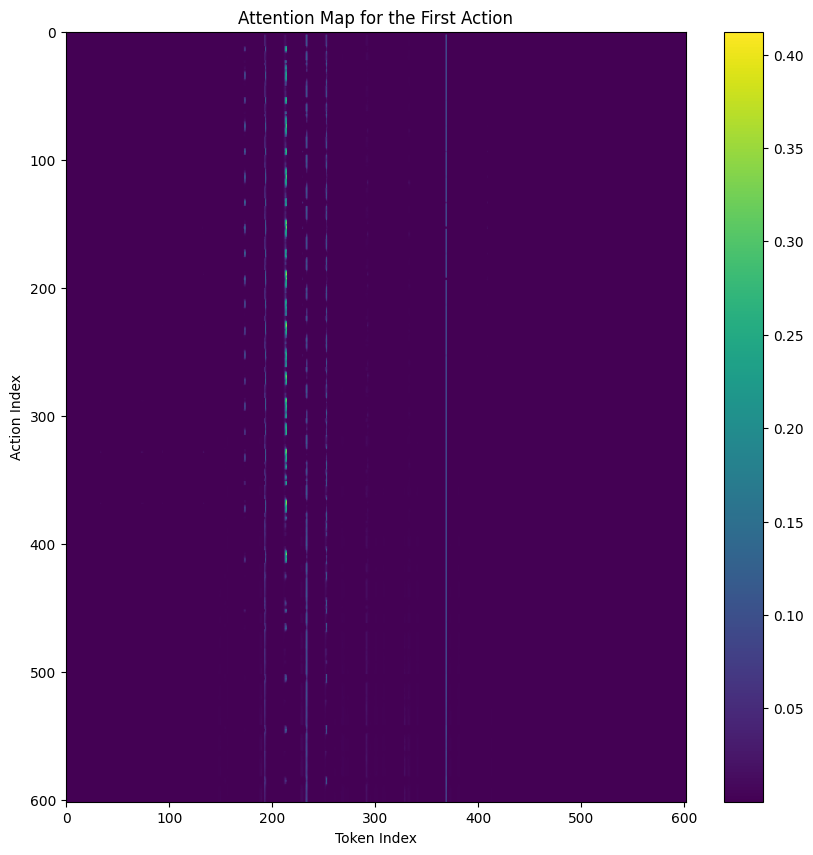

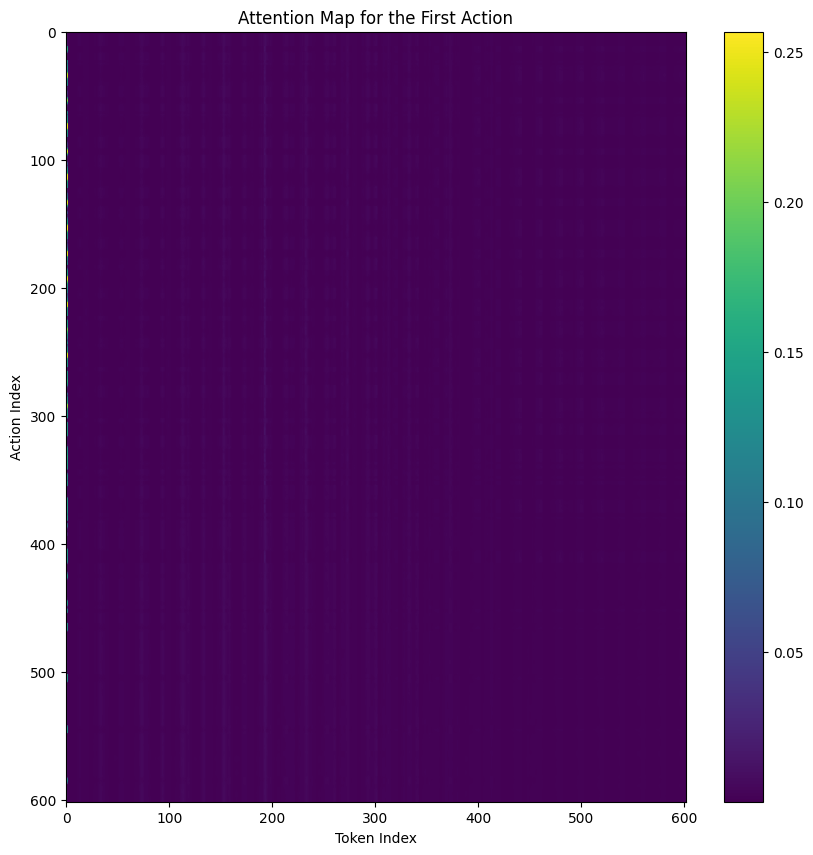

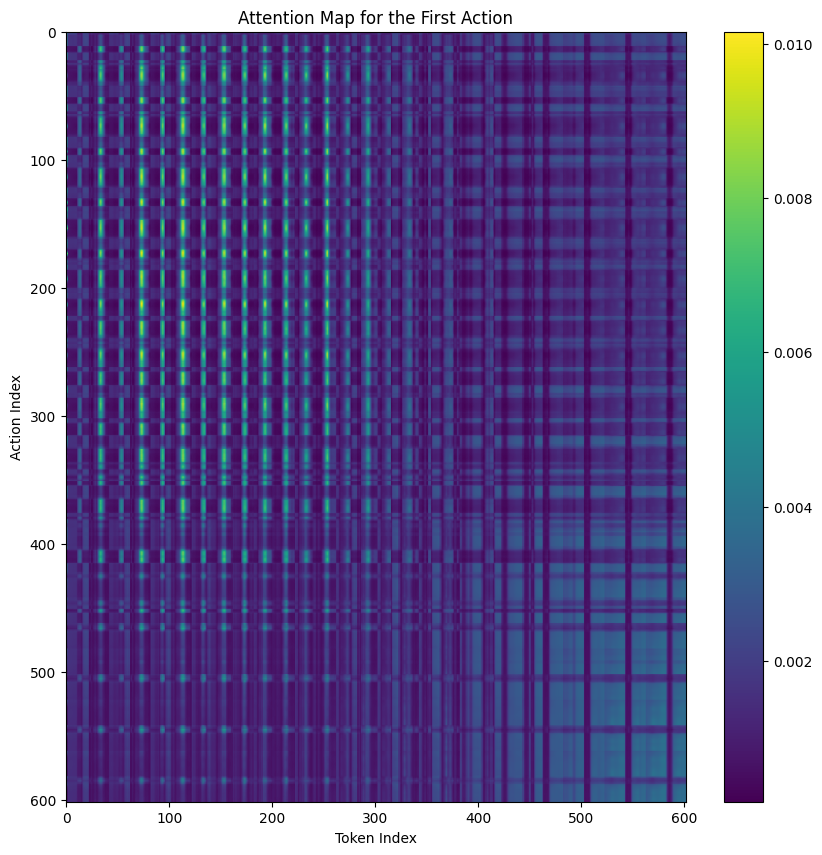

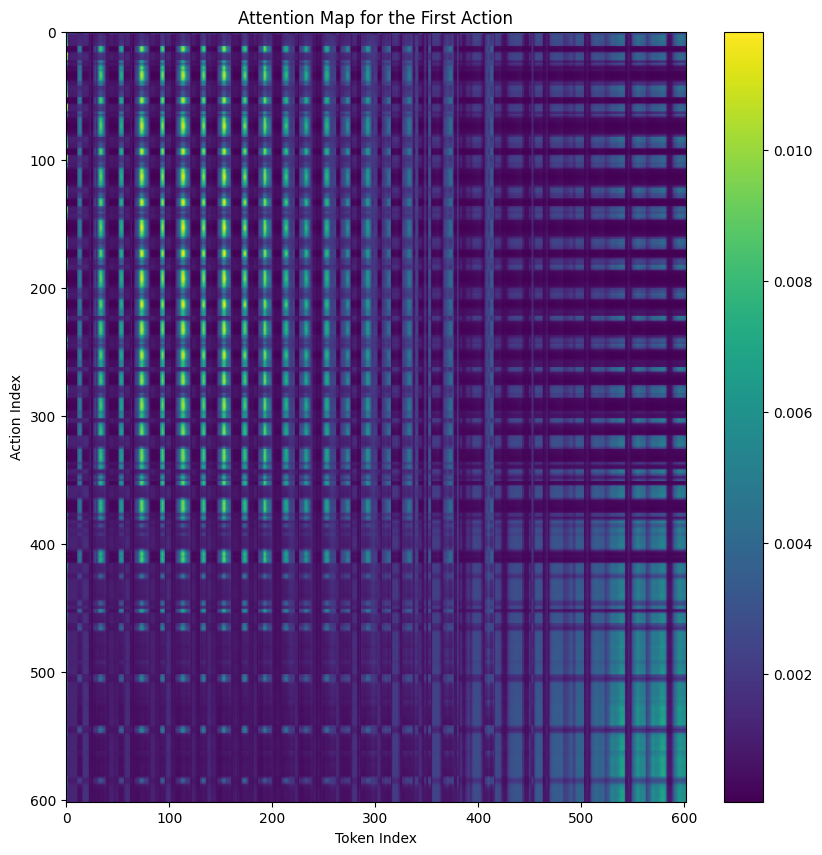

In [185]:
for encoder_map in encoder_atten_map_lst:
    encoder_map = encoder_map.squeeze(0).detach().numpy() # (602, 602)
    plot_full_atten_map(encoder_map)

In [182]:
encoder_first_layer_atten_map = encoder_atten_map_lst[0].squeeze(0).detach().numpy() # (602, 602)
column_sums = encoder_first_layer_atten_map.sum(axis=0)

# Find the index of the column with the maximum sum
max_sum_column_index = np.argmax(column_sums)

# Get the column with the maximum sum
max_sum_column = encoder_first_layer_atten_map[:, max_sum_column_index]

max_sum_column_index

213

In [ ]:
# policy.model.encoder.layers
# model input is 602 tokens, each in dim=512. 300 pixels from 2 camers, 1 from robot state, 1 from latent sample

### we represent the 6dof state of the robot as single token, we could also represent it as 6 tokens

# they go to 3 layers of encoder -atten + mlp. all token are talking to each other

### so now let's look on the stream of single tokens.
# one option is that the token that represents the robot state 
# is sucking the information from the other tokens
# now convey all the information to what need to be modified in the robot state
# another option is that the pixels are sucking the information from the robot state
# creating what the net scence should be
# what does the condition token does?
# it will be interesting to see the attention map of the encoder
# since it can reveall the information flow between the tokens

# so let's do the following:
# the attention map of the decoder hass 100 rows and 602 columns
# the i j enry answering the question how much action i attened to token j
# so first we want to look only on the first column (or row im not sure)
# which will tell in which from the 602 tokens most of the info for the next token is in.
# we did it and found:
# for the input image, while the cube in initial bottom right pos (ep_idx=0) 
# the action is only looking at 5 to 12 tokens 

# so now lets retturn to the *encoder* inputs! and figure out who are they those tokens!
# one conclusion is that the info wan't flow to the robot state token during the encoding phase.
# since it has low value (atten value to token 1 is low)
# this means that the info of the robot state token is being spread to the other tokens
# where and how?

# before that I lokked on the dynamics of the token in the decoder. 
# it seems that different pixels token are beng attend during the roloout
# which make sense. early evidence to transition where the arm grab the cube

# but also to take the 602 output tokens and see what information is in each token
#  list of info pices:
# 1. robot state (6 different questions)
# 2. cube location 


# the output of the encoder is 602 tokens, each in dim=512
# those token enter the decoder. it has 100 "empty" tokens, 
# each of this 100 token transformed to a query
# and the 602 tokens from the encoder are the keys and values
# then we have multihead attention + mlp 
# which are quering the encoder output to assign an action to each token



In [106]:
batch_size = batch["observation.images"].shape[0]
latent_sample = torch.zeros([batch_size, policy.model.config.latent_dim], dtype=torch.float32).to(batch["observation.state"].device)
# Prepare transformer encoder inputs.
encoder_in_tokens = [policy.model.encoder_latent_input_proj(latent_sample)]
encoder_in_pos_embed = list(policy.model.encoder_1d_feature_pos_embed.weight.unsqueeze(1))
# Robot state token.
encoder_in_tokens.append(policy.model.encoder_robot_state_input_proj(batch["observation.state"]))

# token 0 - latent sample
# token 1 - robot state

# Camera observation features and positional embeddings.
all_cam_features = []
for cam_index in range(batch["observation.images"].shape[-4]):
    cam_features = policy.model.backbone(batch["observation.images"][:, cam_index])["feature_map"]
    cam_features = policy.model.encoder_img_feat_input_proj(cam_features)  # (B, C, h, w)
    all_cam_features.append(cam_features)
# Concatenate camera observation feature maps and positional embeddings along the width dimension, and move to (sequence, batch, dim).
all_cam_features = torch.cat(all_cam_features, axis=-1)
encoder_in_tokens.extend(einops.rearrange(all_cam_features, "b c h w -> (h w) b c"))
# encoder_in_tokens = torch.stack(encoder_in_tokens, axis=0)


In [126]:
token_weights = atten_out[1][0][0] 
token_weights[token_weights > 0.03]

tensor([0.0348, 0.0375, 0.0748, 0.0525, 0.0360, 0.0507, 0.0332, 0.0375, 0.0555,
        0.0383], grad_fn=<IndexBackward0>)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(5408, 10)  # Assume input image size is (1, 28, 28)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

model = SimpleCNN()

# Define a hook function
def forward_hook(module, input, output):
    print("Inside forward hook")
    print("Module:", module)
    print("Input shape:", input[0].shape)
    print("Output shape:", output.shape)

# Register the forward hook on the conv1 layer
hook_handle = model.conv1.register_forward_hook(forward_hook)

# Forward pass to trigger the hook
input_data = torch.randn(1, 1, 28, 28)  # Random input data
output = model(input_data)

# Remove the hook when it's no longer needed
hook_handle.remove()


# 0.3 fine tune only MLP

In [ ]:
# I Hyppthesized that the memorization part is on the mlp layers.  
# the input vector to this layers in my point of view represent the wholoe env vorrectlly. 
# therfore it is sufficent to fine tune only the mlp layers to get the model to succeed in other initial locations tasks.

In [ ]:
from torch.cuda.amp import GradScaler
from lerobot.common.datasets.utils import cycle
import time
from contextlib import nullcontext
from lerobot.common.policies.policy_protocol import PolicyWithUpdate
from tqdm import tqdm

In [7]:
repo_id = "yanivmel1/fine_tune_1"
fps = 30
chunk_size = 100
image_transforms = None 
video_backend = 'pyav'
split='train'
delta_timestamps = create_delta_timestamps(fps, chunk_size)
dataset = LeRobotDataset(repo_id, split=split, delta_timestamps=delta_timestamps, image_transforms=image_transforms, video_backend=video_backend)
modify_to_resnet_stats(dataset)

Fetching 46 files:   0%|          | 0/46 [00:00<?, ?it/s]

In [8]:
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
keep_grad = [
"model.decoder.layers.0.linear1.weight",
"model.decoder.layers.0.linear1.bias",
"model.decoder.layers.0.linear2.weight",
"model.decoder.layers.0.linear2.bias",
"model.decoder.layers.0.norm3.weight",
"model.decoder.layers.0.norm3.bias",
"model.action_head.weight",
"model.action_head.bias"
]
for name, param in policy.named_parameters():
    if name not in keep_grad:  
        param.requires_grad = False

# Verify which layers are trainable
for name, param in policy.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [10]:
lr = 1e-5
lr_backbone = 1e-5
batch_size = 8
weight_decay = 1e-4
grad_clip_norm = 10
online_steps_between_rollouts = 1

In [11]:
optimizer_params_dicts = [
    {"params": [p for n, p in policy.named_parameters()
            if not n.startswith("model.backbone") and p.requires_grad]},
    {"params": [p for n, p in policy.named_parameters()
            if n.startswith("model.backbone") and p.requires_grad],
            "lr": lr_backbone,},]
optimizer = torch.optim.AdamW(optimizer_params_dicts, lr=lr, weight_decay=weight_decay)
lr_scheduler = None

In [12]:
use_amp = False
grad_scaler = GradScaler(enabled=use_amp)
step = 0  # number of policy updates (forward + backward + optim)
num_learnable_params = sum(p.numel() for p in policy.parameters() if p.requires_grad)
num_total_params = sum(p.numel() for p in policy.parameters())
print(f"Number of learnable parameters: {num_learnable_params}")
print(f"Number of total parameters: {num_total_params}")

Number of learnable parameters: 3284614
Number of total parameters: 51597238


In [20]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=16,
    batch_size=batch_size,
    shuffle=True,
    sampler=None,
    pin_memory=device.type != "cpu",
    drop_last=False,
)
dl_iter = cycle(dataloader)

In [15]:
def log_train_info(info, step, dataset):
    loss = info["loss"]
    grad_norm = info["grad_norm"]
    lr = info["lr"]
    update_s = info["update_s"]
    dataloading_s = info["dataloading_s"]
    num_samples = (step + 1) * batch_size
    avg_samples_per_ep = dataset.num_samples / dataset.num_episodes
    num_episodes = num_samples / avg_samples_per_ep
    num_epochs = num_samples / dataset.num_samples
    log_items = [
        f"step:{step}",
        # number of samples seen during training
        f"smpl:{num_samples}",
        # number of episodes seen during training
        f"ep:{num_episodes}",
        # number of time all unique samples are seen
        f"epch:{num_epochs:.2f}",
        f"loss:{loss:.3f}",
        f"grdn:{grad_norm:.3f}",
        f"lr:{lr:0.1e}",
        # in seconds
        f"updt_s:{update_s:.3f}",
        f"data_s:{dataloading_s:.3f}",  # if not ~0, you are bottlenecked by cpu or io
    ]
    print(" ".join(log_items))

In [16]:
def update_policy(
    device,
    policy,
    batch,
    optimizer,
    grad_clip_norm,
    grad_scaler: GradScaler,
    lr_scheduler=None,
    use_amp: bool = False,
    lock=None,
):
    """Returns a dictionary of items for logging."""
    start_time = time.perf_counter()
    policy.train()
    with torch.autocast(device_type=device.type) if use_amp else nullcontext():
        output_dict = policy.forward(batch)
        # TODO(rcadene): policy.unnormalize_outputs(out_dict)
        loss = output_dict["loss"]
    grad_scaler.scale(loss).backward()

    # Unscale the graident of the optimzer's assigned params in-place **prior to gradient clipping**.
    grad_scaler.unscale_(optimizer)

    grad_norm = torch.nn.utils.clip_grad_norm_(
        policy.parameters(),
        grad_clip_norm,
        error_if_nonfinite=False,
    )

    # Optimizer's gradients are already unscaled, so scaler.step does not unscale them,
    # although it still skips optimizer.step() if the gradients contain infs or NaNs.
    with lock if lock is not None else nullcontext():
        grad_scaler.step(optimizer)
    # Updates the scale for next iteration.
    grad_scaler.update()

    optimizer.zero_grad()

    if lr_scheduler is not None:
        lr_scheduler.step()

    if isinstance(policy, PolicyWithUpdate):
        # To possibly update an internal buffer (for instance an Exponential Moving Average like in TDMPC).
        policy.update()

    info = {
        "loss": loss.item(),
        "grad_norm": float(grad_norm),
        "lr": optimizer.param_groups[0]["lr"],
        "update_s": time.perf_counter() - start_time,
        **{k: v for k, v in output_dict.items() if k != "loss"},
    }
    info.update({k: v for k, v in output_dict.items() if k not in info})

    return info


In [ ]:
policy.train()
offline_steps = 80000
offline_step = 0
grad_clip_norm = 10
log_freq = 100
save_freq = 10000

for _ in tqdm(range(step, offline_steps)):
    start_time = time.perf_counter()
    batch = next(dl_iter)
    dataloading_s = time.perf_counter() - start_time

    for key in batch:
        batch[key] = batch[key].to(device, non_blocking=True)

    train_info = update_policy(
        device,
        policy,
        batch,
        optimizer,
        grad_clip_norm,
        grad_scaler=grad_scaler,
        lr_scheduler=lr_scheduler,
        use_amp=use_amp,
    )

    train_info["dataloading_s"] = dataloading_s

    if step % log_freq == 0:
        log_train_info(train_info, step, dataset)

    if step % save_freq == 0  or step == offline_steps:
        step_identifier = f"{step:0{5}d}" 
        save_dir = os.path.join("checkpoints", step_identifier)
        policy.save_pretrained(save_dir)
        print("Resume training")

    step += 1
    offline_step += 1 

# 0.4 grokking - try to move from memorization to generalization

In [ ]:
# load two datasets 
# load pretrained model (on 5 sessions)
# keep training only the mlp layer on the 5 locations datsets
# evry n steps eval on 2 novel location (start with eval to get baseline)
# get stats

# considertaions:
# weight decay coefficent
# num of epocs

In [ ]:
training_data_repo_id = "yanivmel1/new_dataset_cube"
val_set_repo_id = "yanivmel1/fine_tune_1"

In [ ]:
# create the following functions:
#1. load datsets (include all data preperation)
#.3 train mlp layer
#